# `webdataset` Streaming

This is an example notebook to show how to use the `webdataset` [format](https://github.com/webdataset/webdataset) in streaming mode.

## Basic exploration

We'll use the [VQGAN Pairs](https://huggingface.co/datasets/dalle-mini/vqgan-pairs) dataset. It is a custom collection of about 2M image pairs that I prepared for super-resolution and image enhancement tests.

Each entry contains just two images:
- A 512x512 crop from an image taken from the [Open Images dataset](https://storage.googleapis.com/openimages/web/index.html). We'll call this the `input` image.
- A 256x256 version of the same crop after being encoded and then decoded with a VQGAN. This will be the `decoded` image.

Webdataset uses the ancient `tar` file format used for tape archival purposes. It is just a collection of files with no other metadata. Webdataset creates virtual records by looking at the file names. For example, given the following 4 files:

```
11329763_91928ff2b7_o.decoded.jpg
11329763_91928ff2b7_o.input.jpg
11349915304_05d4459fae_o.decoded.jpg
11349915304_05d4459fae_o.input.jpg
```

`webdataset` would match the filenames (ignoring the extension), and expose them as two records with entries called `decoded.jpg` and `input.jpg`. If this dataset had captions stored in a file with extension `.txt`, then another entry would be added with the name `txt`.

Note: the `tar` format is sequential. When preparing the dataset make sure that files belonging to the same record are stored one after the other.

We specify the names of the files we want to download using [brace expansion](https://pypi.org/project/braceexpand/).

In [1]:
import braceexpand
import webdataset as wds

In [2]:
files = "{00001..00954}.tar"
urls = f"https://huggingface.co/datasets/dalle-mini/vqgan-pairs/resolve/main/data/{files}"

### Preview

Let's take an initial look at the API.

In [3]:
pil_dataset = (
    wds.WebDataset(urls, handler=wds.warn_and_continue) # Handler is optional
    .decode("pil")                                      # Decode potential images as PIL
    .to_tuple("decoded.jpg", "input.jpg")               # Place _only_ these entries in a tuple
    .batched(4))                                        # Return batches of 4 items

In [4]:
%%time
decoded, inputs = next(iter(pil_dataset))

CPU times: user 78.9 ms, sys: 21.4 ms, total: 100 ms
Wall time: 1.45 s


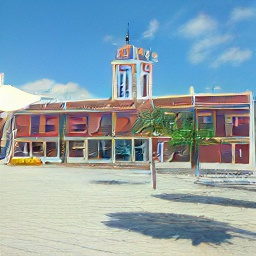

In [5]:
decoded[0]

(The decoded quality is very crappy because we used a VQGAN with a very high `f16` compression factor).

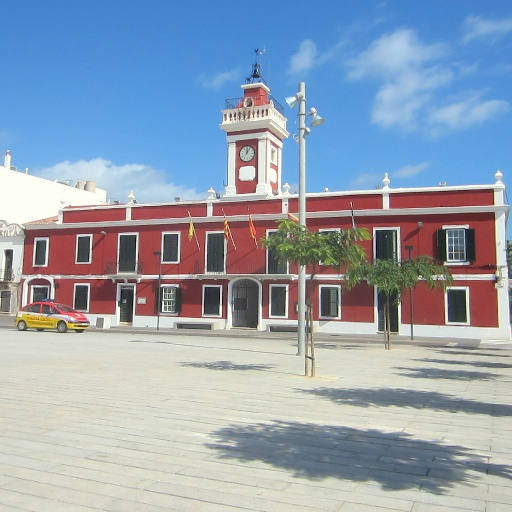

In [6]:
inputs[0]

## Stream, decode, tensorize and batch

This is a more realistic use: we'll be producing batches of tensors.

You can use any normalization or preparation tasks you need for the model you'll use.

In [7]:
import torch
import torchvision.transforms as T

In [8]:
bs = 32

In [9]:
preprocess_image = T.Compose([
    T.ToTensor(),
    lambda t: t.permute(1, 2, 0)   # Reorder, if needed, or do whatever stuff you need.
])

def preprocess(sample):
    # We are changing the keys too (decoded.jpg -> decoded)
    return {
        "decoded": preprocess_image(sample["decoded.jpg"]),
        "input": preprocess_image(sample["input.jpg"])
    }

In [10]:
dataset = (wds.WebDataset(urls, handler=wds.warn_and_continue)
           .shuffle(2500)
           .decode("pil")
           .map(preprocess)
           .to_tuple("decoded", "input")
           .batched(bs))

In [11]:
decoded, inputs = next(iter(dataset))

In [12]:
decoded.shape, inputs.shape

(torch.Size([32, 256, 256, 3]), torch.Size([32, 512, 512, 3]))

## Create Data Loader

It is [usually recommended](https://github.com/webdataset/webdataset) to avoid batching in the `DataLoader`; instead, batch the dataset and then rebatch (if necessary) after the loader.

In [13]:
num_workers = 8

In [14]:
dl = wds.WebLoader(
    dataset,
    batch_size=None,
    num_workers=num_workers
)
dl = dl.unbatched().batched(bs)   # batch size could be different here

We are now ready to use this dataloader in a training loop.

In [15]:
import itertools
from tqdm import tqdm

def do_loop(dl):
    max_samples = 3200
    for (decoded, inputs) in tqdm(itertools.islice(dl, max_samples // bs), total=max_samples//bs):
        # do something with these images
        pass

In [16]:
do_loop(dl)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.16it/s]
